In [80]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor


# Завантаження набору даних
data = pd.read_pickle('mod_05_topic_10_various_data.pkl')
# Витяг даних за ключем 'autos'
df = data['autos']

# Перевірка структури витягнутого DataFrame
print(df.head()) 

          make fuel_type aspiration  ...  city_mpg highway_mpg  price
0  alfa-romero       gas        std  ...        21          27  13495
1  alfa-romero       gas        std  ...        21          27  16500
2  alfa-romero       gas        std  ...        19          26  16500
3         audi       gas        std  ...        24          30  13950
4         audi       gas        std  ...        18          22  17450

[5 rows x 24 columns]


In [81]:
# Додавання нової ознаки 'stroke_ratio'
df['stroke_ratio'] = df['stroke'] / df['bore']

# Перевірка нової ознаки
print(df[['stroke', 'bore', 'stroke_ratio']].head())


   stroke  bore  stroke_ratio
0    2.68  3.47      0.772334
1    2.68  3.47      0.772334
2    3.47  2.68      1.294776
3    3.40  3.19      1.065831
4    3.40  3.19      1.065831


### 2. Визначте перелік дискретних ознак (в широкому розумінні) для подальшого розрахунку показника взаємної інформації.


In [82]:
print(df.dtypes)


make                  object
fuel_type             object
aspiration            object
num_of_doors           int64
body_style            object
drive_wheels          object
engine_location       object
wheel_base           float64
length               float64
width                float64
height               float64
curb_weight            int64
engine_type           object
num_of_cylinders       int64
engine_size            int64
fuel_system           object
bore                 float64
stroke               float64
compression_ratio      int64
horsepower             int64
peak_rpm               int64
city_mpg               int64
highway_mpg            int64
price                  int64
stroke_ratio         float64
dtype: object


In [83]:
# Виявлення дискретних ознак
discrete_features = df.select_dtypes(include=['object', 'int']).columns.tolist()

print("Дискретні ознаки:")
print(discrete_features)

Дискретні ознаки:
['make', 'fuel_type', 'aspiration', 'num_of_doors', 'body_style', 'drive_wheels', 'engine_location', 'curb_weight', 'engine_type', 'num_of_cylinders', 'engine_size', 'fuel_system', 'compression_ratio', 'horsepower', 'peak_rpm', 'city_mpg', 'highway_mpg', 'price']


In [84]:
# Створення DataFrame з дискретними ознаками
discrete_features_df = pd.DataFrame({'Discrete Features': discrete_features})
# Виведення таблиці в стандартному вигляді
from IPython.display import display

display(discrete_features_df)

,Discrete Features
0,make
1,fuel_type
2,aspiration
3,num_of_doors
4,body_style
5,drive_wheels
6,engine_location
7,curb_weight
8,engine_type
9,num_of_cylinders


### 3. Розрахуйте показник взаємної інформації для вхідних ознак і цільової змінної price за допомогою методу mutual_info_regression() з пакета sklearn.

In [85]:
# Перетворення категоріальних ознак у числовий формат
X = df.drop(columns=['price'])  # Всі вхідні ознаки
y = df['price']  # Цільова змінна

# Використання One-Hot Encoding для категоріальних змінних
X = pd.get_dummies(X, drop_first=False)  # Не використовуємо drop_first, щоб врахувати всі категорії

# Обчислення взаємної інформації
mi_scores = mutual_info_regression(X, y)

# Створення таблиці з результатами
mi_scores_df = pd.DataFrame({
    'Feature': X.columns,
    'Mutual Information Score': mi_scores
}).sort_values(by='Mutual Information Score', ascending=False)

# Виведення результатів
print(mi_scores_df)


                   Feature  Mutual Information Score
5              curb_weight                  0.913613
7              engine_size                  0.912836
14             highway_mpg                  0.890647
11              horsepower                  0.885351
13                city_mpg                  0.798843
..                     ...                       ...
41  body_style_convertible                  0.000000
54        engine_type_ohcf                  0.000000
50    engine_location_rear                  0.000000
49   engine_location_front                  0.000000
59         fuel_system_mfi                  0.000000

[63 rows x 2 columns]


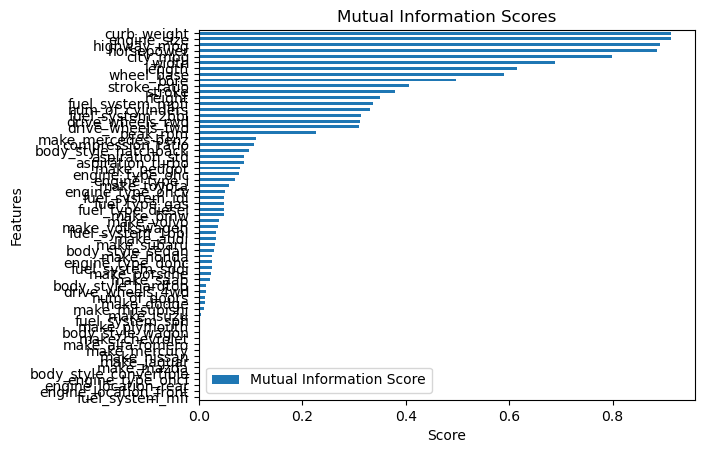

In [86]:
# Побудова графіка
mi_scores_df.plot(x='Feature', y='Mutual Information Score', kind='barh')
plt.title("Mutual Information Scores")
plt.xlabel("Score")
plt.ylabel("Features")
plt.gca().invert_yaxis()  # Інвертуємо осі для кращого вигляду
plt.show()


### 4. Побудуйте регресійну модель / ансамбль 

In [87]:
# Копія даних для підготовки
X = df.drop(columns=['price'])
y = df['price']

from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(drop=None, sparse_output=False)
X_encoded = ohe.fit_transform(X.select_dtypes(include=['object']))

# Замінюємо категоріальні колонки в X на закодовані
encoded_columns = ohe.get_feature_names_out(X.select_dtypes(include=['object']).columns)
X = pd.concat(
    [pd.DataFrame(X_encoded, columns=encoded_columns), X.select_dtypes(exclude=['object'])],
    axis=1
)


# Поділ даних на тренувальну та тестову вибірки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Побудова моделі RandomForestRegressor

In [88]:
# Ініціалізація та навчання моделі
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Оцінка важливості ознак
feature_importance = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

# Виведення результатів
print("Feature Importance:")
print(feature_importance)


Feature Importance:
engine_size        4.435059e-01
curb_weight        4.271370e-01
width              1.972713e-02
horsepower         1.949719e-02
highway_mpg        1.781227e-02
                       ...     
make_plymouth      4.433820e-06
make_chevrolet     1.594390e-06
fuel_system_mfi    8.049551e-07
make_jaguar        2.738999e-07
make_mercury       0.000000e+00
Length: 63, dtype: float64


### Побудова графіка важливості ознак

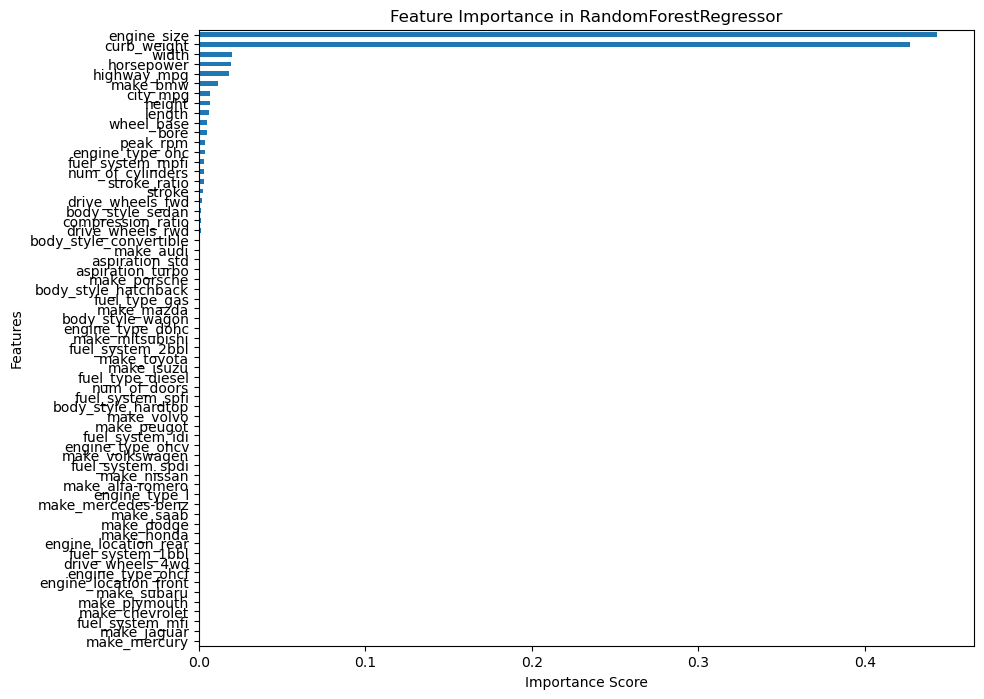

In [89]:
# Візуалізація важливості ознак
feature_importance.plot(kind='barh', figsize=(10, 8))
plt.title("Feature Importance in RandomForestRegressor")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.gca().invert_yaxis()  
plt.show()


### Побудова моделі  GradientBoostingRegressor

In [90]:
# Ініціалізація та навчання моделі
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)

# Оцінка важливості ознак
gb_feature_importance = pd.Series(gb_model.feature_importances_, index=X.columns).sort_values(ascending=False)

# Виведення результатів
print("Feature Importance (GradientBoostingRegressor):")
print(gb_feature_importance)


Feature Importance (GradientBoostingRegressor):
curb_weight              0.466616
engine_size              0.327256
horsepower               0.063670
width                    0.024157
highway_mpg              0.022576
                           ...   
fuel_system_idi          0.000000
engine_location_rear     0.000000
engine_location_front    0.000000
fuel_system_1bbl         0.000000
engine_type_l            0.000000
Length: 63, dtype: float64


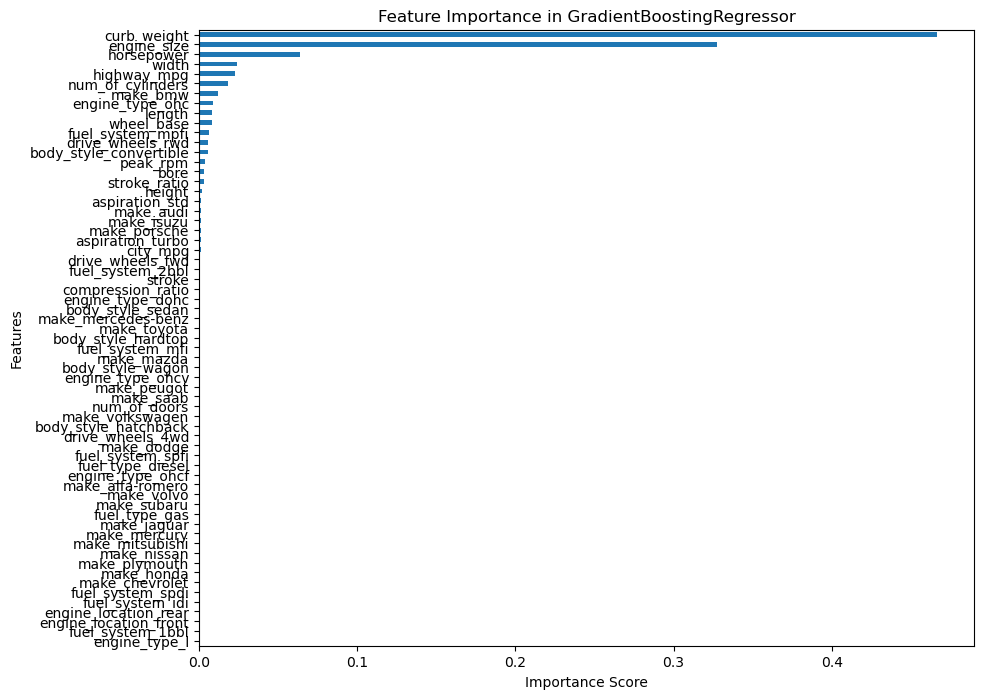

In [91]:
# Візуалізація важливості ознак
gb_feature_importance.plot(kind='barh', figsize=(10, 8))
plt.title("Feature Importance in GradientBoostingRegressor")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.gca().invert_yaxis()  # Інвертуємо осі для кращого вигляду
plt.show()

### RandomForestRegressor:
    - Найважливішими ознаками є engine_size, curb_weight, і horsepower. Вони отримали найвищі бали важливості.
    - Інші ознаки мають значно менший вплив, і важливість швидко знижується для менш релевантних ознак.
### GradientBoostingRegressor:
    - Аналогічно, curb_weight, engine_size, і horsepower також мають найвищу важливість, що підтверджує їх ключову роль у прогнозуванні price.
    - Однак, градієнтний бустинг трохи сильніше концентрується на цих ознаках, відсікаючи важливість менш релевантних ознак ще більш різко.

### Ключові ознаки:
- В обох моделях engine_size, curb_weight, і horsepower є найважливішими.
- Це свідчить про те, що ці три змінні найбільше впливають на ціну автомобіля, і їх слід розглядати як основні при побудові моделі.

### Слабкі ознаки:
- Ознаки, такі як engine_location, fuel_type, і num_of_doors, мають дуже низьку важливість в обох моделях.
- Це означає, що вони мають слабкий або нульовий вплив на прогноз ціни і можуть бути вилучені для спрощення моделі.

### Висновок:
- Обидві моделі узгоджуються у визначенні ключових ознак, що підтверджує їх надійність.
- Водночас, GradientBoostingRegressor більше акцентує важливість на топ-3 ознаках, що може свідчити про його здатність краще відсікати шум.

### Крок 5. Масштабуйте / уніфікуйте різні за своєю природою показники

In [92]:
# Перевірка розмірів даних
print(f"Shapes of inputs:")
print(f"mi_scores_df: {mi_scores_df.shape}")
print(f"feature_importance: {feature_importance.shape}")
print(f"gb_feature_importance: {gb_feature_importance.shape}")



Shapes of inputs:
mi_scores_df: (63, 2)
feature_importance: (63,)
gb_feature_importance: (63,)


In [93]:


# Перевірка індексів та значень
print("Індекси mi_scores_df:")
print(mi_scores_df.index)
print("Значення стовпця Feature у mi_scores_df:")
print(mi_scores_df['Feature'].head())

print("Індекси feature_importance:")
print(feature_importance.index)
print("Значення feature_importance:")
print(feature_importance.head())

print("Індекси gb_feature_importance:")
print(gb_feature_importance.index)
print("Значення gb_feature_importance:")
print(gb_feature_importance.head())



Індекси mi_scores_df:
Index([ 5,  7, 14, 11, 13,  3,  2,  1,  8, 15,  9,  4, 60,  6, 57, 48, 47, 12,
       25, 10, 43, 39, 40, 29, 53, 52, 34, 55, 58, 38, 37, 18, 36, 35, 56, 17,
       33, 44, 21, 51, 61, 31, 32, 42, 46,  0, 20, 27, 22, 62, 30, 45, 19, 16,
       26, 28, 23, 24, 41, 54, 50, 49, 59],
      dtype='int64')
Значення стовпця Feature у mi_scores_df:
5     curb_weight
7     engine_size
14    highway_mpg
11     horsepower
13       city_mpg
Name: Feature, dtype: object
Індекси feature_importance:
Index(['engine_size', 'curb_weight', 'width', 'horsepower', 'highway_mpg',
       'make_bmw', 'city_mpg', 'height', 'length', 'wheel_base', 'bore',
       'peak_rpm', 'engine_type_ohc', 'fuel_system_mpfi', 'num_of_cylinders',
       'stroke_ratio', 'stroke', 'drive_wheels_fwd', 'body_style_sedan',
       'compression_ratio', 'drive_wheels_rwd', 'body_style_convertible',
       'make_audi', 'aspiration_std', 'aspiration_turbo', 'make_porsche',
       'body_style_hatchback', 'fuel_type

In [96]:
# Об'єднання даних за ознаками
comparison_df = mi_scores_df[['Feature', 'Mutual Information Score']].copy()

# Додаємо Random Forest і Gradient Boosting важливості за назвами ознак
comparison_df = comparison_df.merge(
    feature_importance.rename('Random Forest Importance'),
    left_on='Feature', right_index=True
)

comparison_df = comparison_df.merge(
    gb_feature_importance.rename('Gradient Boosting Importance'),
    left_on='Feature', right_index=True
)

# Масштабування взаємної інформації
comparison_df['Mutual Information Score'] /= comparison_df['Mutual Information Score'].sum()

# Додавання ранжування
comparison_df['MI Rank'] = comparison_df['Mutual Information Score'].rank(pct=True, method='average')
comparison_df['RF Rank'] = comparison_df['Random Forest Importance'].rank(pct=True, method='average')
comparison_df['GB Rank'] = comparison_df['Gradient Boosting Importance'].rank(pct=True, method='average')


# Виведення результатів
print(comparison_df)


                   Feature  Mutual Information Score  ...   RF Rank   GB Rank
5              curb_weight                  0.081880  ...  0.984127  1.000000
7              engine_size                  0.081810  ...  1.000000  0.984127
14             highway_mpg                  0.079821  ...  0.936508  0.936508
11              horsepower                  0.079347  ...  0.952381  0.968254
13                city_mpg                  0.071594  ...  0.904762  0.650794
..                     ...                       ...  ...       ...       ...
41  body_style_convertible                  0.000000  ...  0.666667  0.809524
54        engine_type_ohcf                  0.000000  ...  0.126984  0.285714
50    engine_location_rear                  0.000000  ...  0.174603  0.142857
49   engine_location_front                  0.000000  ...  0.111111  0.142857
59         fuel_system_mfi                  0.000000  ...  0.047619  0.492063

[63 rows x 7 columns]


In [99]:
# Виведення всіх стовпців
pd.set_option('display.max_columns', None)

# Перевіряємо результат
print(comparison_df)

                   Feature  Mutual Information Score  \
5              curb_weight                  0.081880   
7              engine_size                  0.081810   
14             highway_mpg                  0.079821   
11              horsepower                  0.079347   
13                city_mpg                  0.071594   
..                     ...                       ...   
41  body_style_convertible                  0.000000   
54        engine_type_ohcf                  0.000000   
50    engine_location_rear                  0.000000   
49   engine_location_front                  0.000000   
59         fuel_system_mfi                  0.000000   

    Random Forest Importance  Gradient Boosting Importance   MI Rank  \
5               4.271370e-01                      0.466616  1.000000   
7               4.435059e-01                      0.327256  0.984127   
14              1.781227e-02                      0.022576  0.968254   
11              1.949719e-02           

### Крок6. Побудуйте візуалізацію типу grouped barsplots 

In [101]:
print(comparison_df.columns)

Index(['Feature', 'Mutual Information Score', 'Random Forest Importance',
       'Gradient Boosting Importance', 'MI Rank', 'RF Rank', 'GB Rank'],
      dtype='object')


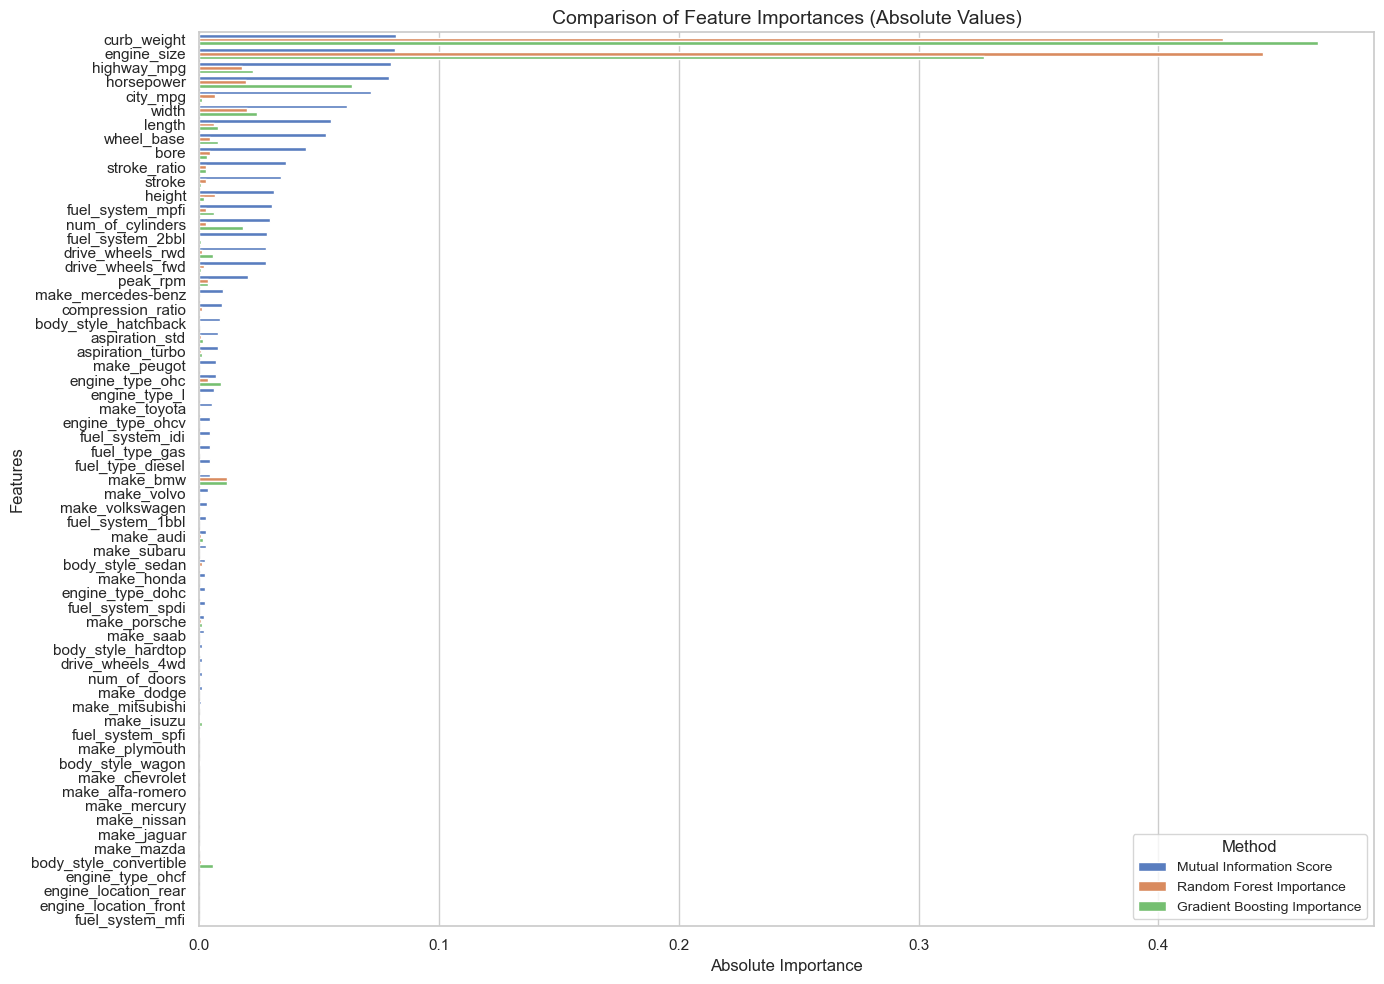

In [103]:
# Переформатування даних для абсолютних значень
abs_melted_df = comparison_df.reset_index().melt(
    id_vars="Feature",  # Переконайся, що Feature є стовпцем
    value_vars=["Mutual Information Score", "Random Forest Importance", "Gradient Boosting Importance"],
    var_name="Method",
    value_name="Importance"
)

# Побудова графіка для абсолютних значень
sns.set(style="whitegrid")
plt.figure(figsize=(14, 10))
sns.barplot(
    data=abs_melted_df,
    x="Importance",
    y="Feature",
    hue="Method",
    palette="muted",
    orient="h"
)

plt.title("Comparison of Feature Importances (Absolute Values)", fontsize=14)
plt.xlabel("Absolute Importance", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.legend(title="Method", fontsize=10, loc="lower right")
plt.tight_layout()
plt.show()


In [105]:
print(comparison_df[['Mutual Information Score', 'Random Forest Importance', 'Gradient Boosting Importance']])


    Mutual Information Score  Random Forest Importance  \
5                   0.081880              4.271370e-01   
7                   0.081810              4.435059e-01   
14                  0.079821              1.781227e-02   
11                  0.079347              1.949719e-02   
13                  0.071594              6.630861e-03   
..                       ...                       ...   
41                  0.000000              8.557834e-04   
54                  0.000000              2.306467e-05   
50                  0.000000              3.141330e-05   
49                  0.000000              1.860159e-05   
59                  0.000000              8.049551e-07   

    Gradient Boosting Importance  
5                       0.466616  
7                       0.327256  
14                      0.022576  
11                      0.063670  
13                      0.000940  
..                           ...  
41                      0.005626  
54                     

In [106]:
print(comparison_df.columns)

Index(['Feature', 'Mutual Information Score', 'Random Forest Importance',
       'Gradient Boosting Importance', 'MI Rank', 'RF Rank', 'GB Rank'],
      dtype='object')


       Feature   Method      Rank
0  curb_weight  MI Rank  1.000000
1  engine_size  MI Rank  0.984127
2  highway_mpg  MI Rank  0.968254
3   horsepower  MI Rank  0.952381
4     city_mpg  MI Rank  0.936508


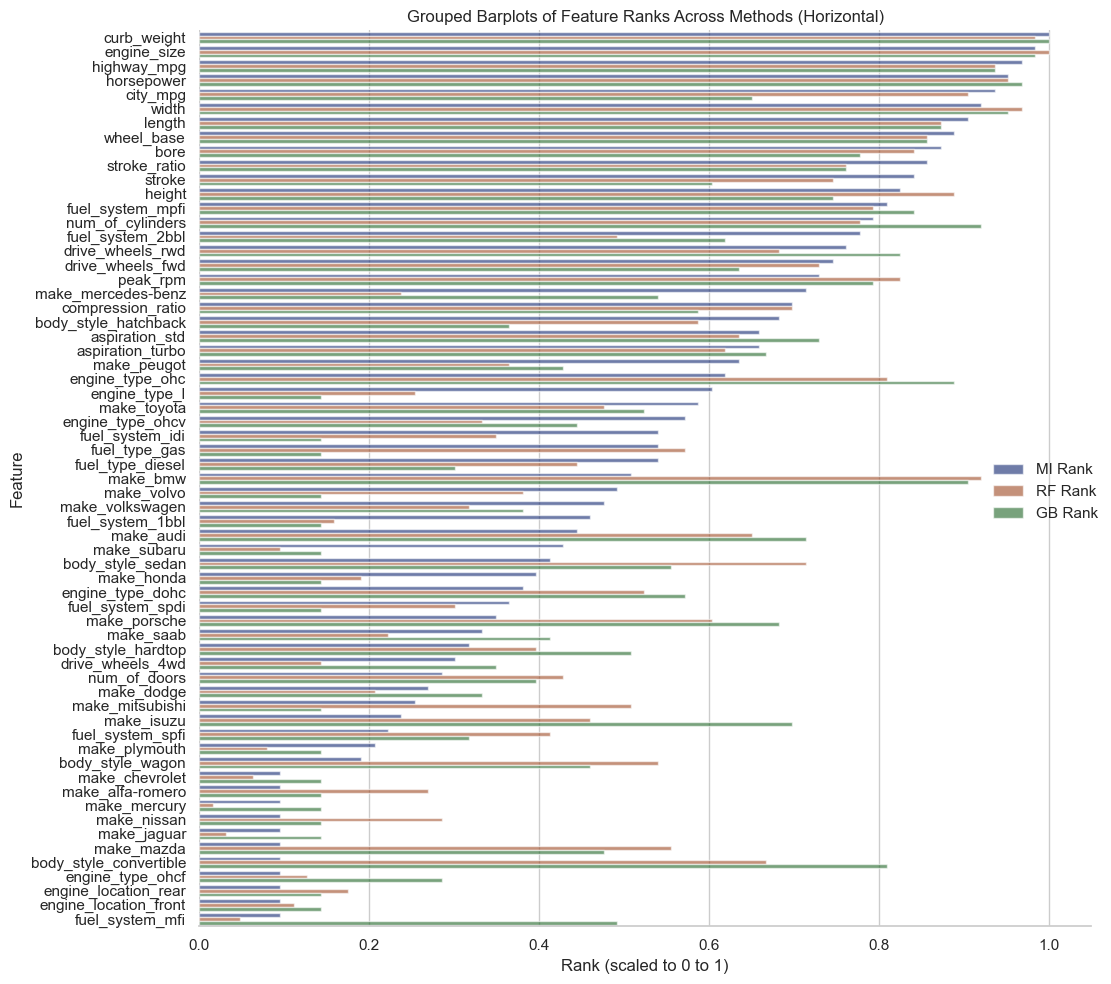

In [107]:
# Підготовка даних у форматі для catplot
melted_df = comparison_df.melt(
    id_vars="Feature",
    value_vars=["MI Rank", "RF Rank", "GB Rank"],
    var_name="Method",
    value_name="Rank"
)

# Перевірка структури
print(melted_df.head())

# Побудова згрупованого barplot
sns.set_theme(style="whitegrid")
g = sns.catplot(
    data=melted_df,
    kind="bar",
    x="Rank",
    y="Feature",
    hue="Method",
    palette="dark",
    alpha=.6,
    height=10,  # Для більшої висоти графіка
    orient="h"
)
g.despine(left=True)
g.set_axis_labels("Rank (scaled to 0 to 1)", "Feature")
g.legend.set_title("")
plt.title("Grouped Barplots of Feature Ranks Across Methods (Horizontal)")
plt.tight_layout()
plt.show()



In [108]:
print(comparison_df[["MI Rank", "RF Rank", "GB Rank"]])

     MI Rank   RF Rank   GB Rank
5   1.000000  0.984127  1.000000
7   0.984127  1.000000  0.984127
14  0.968254  0.936508  0.936508
11  0.952381  0.952381  0.968254
13  0.936508  0.904762  0.650794
..       ...       ...       ...
41  0.095238  0.666667  0.809524
54  0.095238  0.126984  0.285714
50  0.095238  0.174603  0.142857
49  0.095238  0.111111  0.142857
59  0.095238  0.047619  0.492063

[63 rows x 3 columns]


                              Mutual Information Score  \
Mutual Information Score                      1.000000   
Random Forest Importance                      0.540818   
Gradient Boosting Importance                  0.564942   

                              Random Forest Importance  \
Mutual Information Score                      0.540818   
Random Forest Importance                      1.000000   
Gradient Boosting Importance                  0.976940   

                              Gradient Boosting Importance  
Mutual Information Score                          0.564942  
Random Forest Importance                          0.976940  
Gradient Boosting Importance                      1.000000  


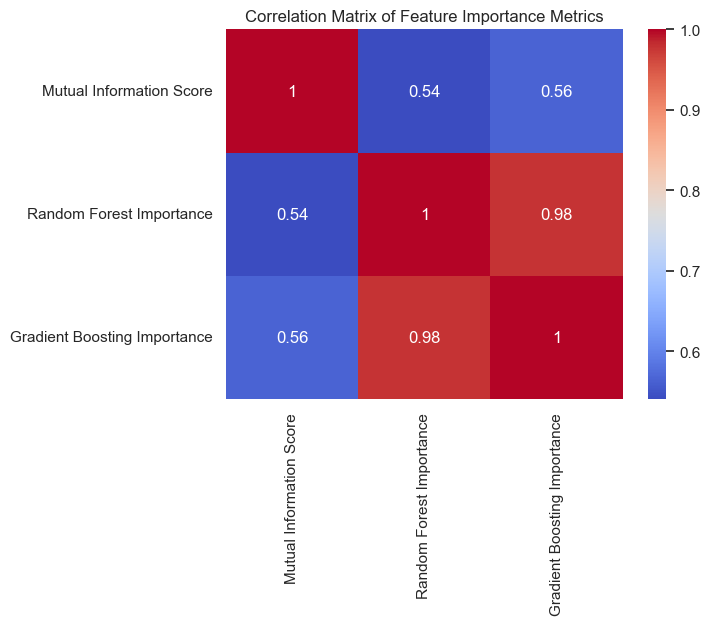

In [110]:
correlation_matrix = comparison_df[["Mutual Information Score", "Random Forest Importance", "Gradient Boosting Importance"]].corr()
print(correlation_matrix)
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix of Feature Importance Metrics")
plt.show()



### 7. Проаналізуйте візуалізацію та зробіть висновки.

1. Порівняння абсолютних значень важливості ознак
На графіку "Comparison of Feature Importances (Absolute Values)":

    - Важливіші ознаки:
        - curb_weight, engine_size, highway_mpg — ці ознаки мають найвищі показники важливості серед усіх трьох методів: Mutual Information, Random Forest Importance та Gradient Boosting Importance.
        - Це означає, що ці фактори найбільше впливають на цільову змінну у всіх підходах.
    - Менш важливі ознаки:
        - Багато інших ознак, такі як fuel_system_mfi, engine_location_rear, engine_type_ohcf, мають дуже низькі значення важливості або дорівнюють 0.
        - Це свідчить, що вони не мають суттєвого впливу на модель і можуть бути відкинуті для оптимізації.
2. Порівняння ранжування ознак
На графіку "Grouped Barplots of Feature Ranks Across Methods (Horizontal)":

    - Ранжування для трьох методів — MI Rank, RF Rank, GB Rank — є схожим для найважливіших ознак:
        - curb_weight та engine_size отримали найвищі місця у всіх методах.
        - Це підтверджує їх ключовий вплив у побудові моделей.
    - Різниця у ранжуванні:
        - У менш важливих ознаках спостерігається відмінність у рангах для кожного методу.
        - Наприклад, метод Gradient Boosting деякі ознаки вважає менш важливими, ніж Random Forest.

### Загальні висновки:
- curb_weight та engine_size є критичними ознаками для моделювання, що підтверджується всіма трьома методами.
- Ознаки з нульовою важливістю можна виключити зі списку для спрощення моделі.
- Метод Mutual Information оцінює важливість ознак без врахування взаємодії між ними, тоді як Random Forest та Gradient Boosting можуть враховувати нелінійні залежності.